In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from surprise import Dataset, Reader
from surprise import SVDpp
from surprise.model_selection import GridSearchCV, cross_validate

In [ ]:
pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195825 sha256=beaa1c3e684c30c6038e0628047911ad6b3752209eb26be25c1c92664f4ced6f
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/GTMSA/Text Mining/project/Reviews.csv')
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
ratings = df[['UserId', 'ProductId', 'Score']]

In [ ]:
len(ratings)

568454

In [ ]:
# Simple SVD recommender
import math
from typing import Tuple, List
from surprise import SVDpp, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, train_test_split

class SVDppRecommender(object):
    def __init__(self) -> None:
        """
        Initialize with nothing
        """
    def load_ratings_datasets(
        self, ratings_df
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Load train and test user-movie ratings datasets
        """
        train = ratings_df.sample(frac = 0.8, random_state = 10086)
        test = ratings_df.drop(train.index)
        return train, test

Matrix Factorization-Based Algorithms

In [ ]:
# try surprise package
from surprise import Reader, SVDpp, accuracy, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV


# when importing from a DF, only need to specify the scale of the ratings.
reader = Reader(rating_scale=(1,5)) 
#Initialize a recommender instance and apply its function using surprise:
recommender = SVDppRecommender()
trainset, testset = recommender.load_ratings_datasets(ratings)

Hyper-tuning for SVDpp parameters
- n factors: 50, 60 （50 better than 55, 50 better than 40， 60better than 70, 50 better than 45）(49 better than 48) (50 better than 49)
- n_epochs: 35, 40
- lr_all: 0.09 (0.25 better than 0.3) (0.12 better than 0.25) (0.09 better than 0.12)
- reg_all: 0.05, 0.1 （0.1 better than 0.05）(0.08 better than 0.1) 0.07 better than 0.08 (0.06 better than 0.07)

In [ ]:
fulldata = Dataset.load_from_df(ratings,reader)
traindata = Dataset.load_from_df(trainset,reader)
testdata = Dataset.load_from_df(testset,reader)

# Define the hyperparameter grid
# SVDpp with sgd, use gridsearch to tune parameters, use a range of factors with default as 4 and 36 as end adn step of 8

param_grid = {
    'n_factors': [49, 50],
    'n_epochs': [35, 40],
    'lr_all': [0.09],
    'reg_all': [0.055, 0.06],
    'random_state': [10086]
}
grid_search = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=8, n_jobs=-1)

grid_search.fit(fulldata)

# best RMSE score
print(grid_search.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(grid_search.best_params["rmse"])


# # print the best hyperparameters and their RMSE score
# print("Best hyperparameters: ", grid_search.best_params['rmse'])
# print("Best RMSE: ", grid_search.best_score['rmse'])

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.9990490491748163
{'n_factors': 50, 'n_epochs': 35, 'lr_all': 0.09, 'reg_all': 0.055, 'random_state': 10086}


In [ ]:
# Choose the best model
best_model = grid_search.best_estimator['rmse']
cross_validate(best_model, fulldata, measures=['RMSE'], cv = 8, verbose = True)

Evaluating RMSE of algorithm SVDpp on 8 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Mean    Std     
RMSE (testset)    1.0003  0.9977  0.9943  0.9973  1.0057  0.9965  0.9977  0.9923  0.9977  0.0038  
Fit time          55.47   51.21   50.07   51.23   49.82   49.43   49.79   48.89   50.74   1.94    
Test time         2.33    2.30    2.60    2.24    1.77    1.74    1.92    2.60    2.19    0.32    


{'test_rmse': array([1.00026709, 0.99766416, 0.99426105, 0.99729609, 1.00568048,
        0.99649705, 0.99774812, 0.99230351]),
 'fit_time': (55.46602988243103,
  51.21329212188721,
  50.07491683959961,
  51.22524666786194,
  49.81822967529297,
  49.434168577194214,
  49.79270792007446,
  48.885212898254395),
 'test_time': (2.3265626430511475,
  2.3010928630828857,
  2.5966691970825195,
  2.2409849166870117,
  1.7705867290496826,
  1.7357499599456787,
  1.9234910011291504,
  2.601006269454956)}

In [20]:
# Evaluate it on the testset with the build_testset() from surprise package
best_model2 = grid_search.best_estimator['rmse']
# Not split the dataset into folds and just return a trainset as is, built from the whole dataset.
# User can then query for predictions
train = fulldata.build_full_trainset()
best_model2.fit(train)
test = train.build_testset()
predictions = best_model2.test(test)

# Calclulate the RMSE for the best model
rmse = accuracy.rmse(predictions)
print("Testset RMSE: ", rmse)

RMSE: 0.1907
Testset RMSE:  0.19073818154897051


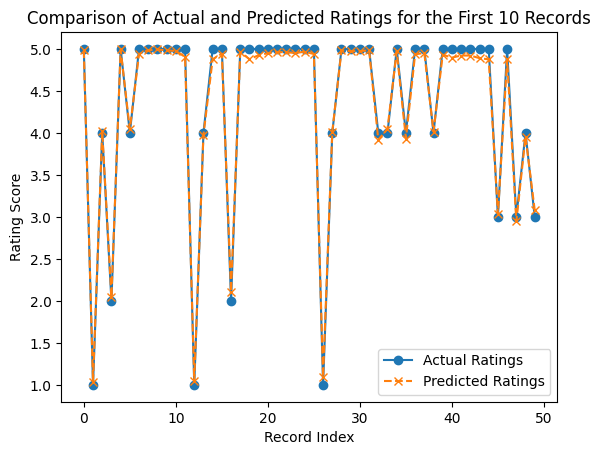

In [25]:
# Get the first 10 records
first_10_records = ratings.iloc[:50]

predictions = []
for _, row in first_10_records.iterrows():
    user_id = row['UserId']
    item_id = row['ProductId']
    true_rating = row['Score']
    pred_rating = best_model.predict(user_id, item_id).est
    predictions.append(pred_rating)

actual_ratings = first_10_records['Score'].tolist()

# Plot the comparison between actual and predicted ratings
plt.plot(actual_ratings, label='Actual Ratings', marker='o', linestyle='-')
plt.plot(predictions, label='Predicted Ratings', marker='x', linestyle='--')
plt.xlabel('Record Index')
plt.ylabel('Rating Score')
plt.legend()
plt.title('Comparison of Actual and Predicted Ratings for the First 50 Records')
plt.show()